In [28]:
%%writefile out.py
import multiprocessing as mp
import logging
import sys
import time

logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
logger = logging.getLogger(__name__)

def worker(queue):
    logger.info('hi')
    queue.put(1)
    return 

if __name__ == '__main__':
    logger.info('hey')
    
    with mp.Pool(4) as pool, mp.Manager() as m:
        queue = m.Queue()
        pool.apply_async(worker, (queue,))
        pool.apply_async(worker, (queue,))
        pool.close()
        pool.join()
        print(queue.get(False, 1))

Overwriting out.py


In [29]:
! python out.py

INFO:__main__:hey
INFO:__mp_main__:hi
INFO:__mp_main__:hi
1


# Polite Webscraper of UCI Datasets
1. Fetch Webpage
2. Fetch Downloads with Normcurved 
3. Fetch Webpage subsets

In [123]:
import sched
import numpy as np
import requests
import bs4
import urllib
import os
from collections import deque

# in this context, has no benefit over time.sleep - just using for practice
s = sched.scheduler()

# a simple queue using deques (deque = double ended queue)
# deque's are threadsafe and have O(1) performance of pop's and appends in either direction
q = deque()

urls = [
    r'https://archive.ics.uci.edu/ml/datasets/Abalone',
]

for url in urls:
    q.append()

def handle_response(url):
    '''
    :param: test
    '''
    url_path = urllib.parse.urlparse(url)[2]
    resp = requests.get(url)
    soup = bs4.BeautifulSoup(resp.text, 'lxml')

    # handle top level
    if url_path.split('/')[-2] == 'datasets':
        data_folder = soup.find('a', text="Data Folder")
        if data_folder is None: 
            raise Exception("Did not find data folder. Perhaps api change")

        # get relative url
        data_folder = data_folder.attrs['href']

        # merge into absolute url
        data_folder = urllib.parse.urljoin(url, data_folder)
        q.append(data_folder)

    # handle folder download
    else:

        # folder
        if resp.url.endswith('/'): 
            _found_parent_dir = False
            for row in soup.find('table').find_all('tr'):
                # only save results below parent dir
                if not _found_parent_dir: 
                    if row.find('td', text='Parent Directory') is not None:
                        _found_parent_dir = True
                    continue

                child_link = row.find('a', href=True)
                if child_link is None: continue 

                child_link = child_link.attrs['href']
                child_link = urllib.parse.urljoin(resp.url, child_link)

                q.append(child_link)

        # file
        else:
            local_folder = os.path.join(*url_path.split('/')[3:-1])
            local_path = os.path.join(*url_path.split('/')[3:])

            if not os.path.exists(local_folder):
                os.makedirs(local_folder)

            with open(local_path, 'wb') as f:
                for chunk in resp.iter_content(chunk_size=1024): 
                    if chunk: # filter out keep-alive new chunks
                        f.write(chunk)
                            
def polite_webscraper():
    try:
        item = q.popleft()
    except IndexError:
        return # No URLs left in queue.
    
    handle_response(item)

    delay = abs(np.random.normal(2.0, 0.25))
    s.enter(delay, 1, foo)
    s.run()
    
polite_webscraper()

SyntaxError: invalid syntax (<ipython-input-123-601d543bb059>, line 20)

In [133]:
! python -m pip install -U pip setuptools

Requirement already up-to-date: pip in c:\users\wolf\anaconda3\lib\site-packages
  Found existing installation: setuptools 25.1.6
    Uninstalling setuptools-25.1.6:
      Successfully uninstalled setuptools-25.1.6


In [1]:
%load_ext Cython

In [2]:
%%cython

cdef int a = 0
for i in range(10):
    a += i
print(a)

CompileError: command 'C:\\Program Files (x86)\\Microsoft Visual Studio\\2017\\Community\\VC\\Tools\\MSVC\\14.10.25017\\bin\\HostX64\\x64\\cl.exe' failed with exit status 2

## Plot Delay Times

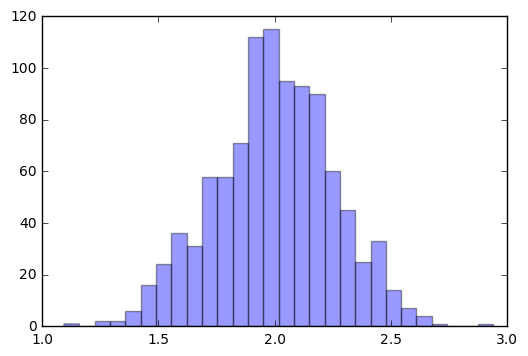

In [68]:
%matplotlib inline
import seaborn as sb
a = np.random.normal(2.0, 0.25, 1000)
sb.distplot(a, kde=False)